<a href="https://colab.research.google.com/github/singhmansi25/Skin-Cancer-Classification/blob/main/SkinCancer_Detection_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing required Libraries**

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os      # Operating system functionality
import random  # Random number generator
import pandas as pd     # Data analysis & manipulation
import numpy as np      # Array-processing
import seaborn as sns   # Data visualization
import matplotlib.pyplot as plt     # Data visualization
import matplotlib.ticker as ticker
import plotly.graph_objs as go
import plotly.express as px
import glob as gb
from PIL import Image

import tensorflow as tf
import tensorflow_hub as hub
from keras.utils.np_utils import to_categorical     # convert to one-hot-encoding
from tensorflow.keras import preprocessing, layers, models, callbacks     # Neural networks
from keras import layers, Sequential
from keras.utils import plot_model, np_utils
from keras.layers import Convolution2D, MaxPool2D, Dropout
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.layers import BatchNormalization 
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint
from keras.applications.mobilenet import MobileNet ,preprocess_input

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import metrics       # Model evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc

In [ ]:
# To train CNN model using GPU in google Colaboratory for faster training and better results.

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## **Importing Dataset from Kaggle**

In [ ]:
# To download dataset directly from kaggle using username and kaggle api.

!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images', force=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: singh25mansi
Your Kaggle Key: ··········


100%|██████████| 98.7M/98.7M [00:00<00:00, 112MB/s] 


In [ ]:
class CFG:
    EPOCHS = 25
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [ ]:
# Path of training and testing dataset

folder_train = '/content/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train/'

folder_test = '/content/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test/'

In [ ]:
%%time

train_images = gb.glob(f"{folder_train}**/*.jpg")

test_images = gb.glob(f"{folder_test}**/*.jpg")

CPU times: user 28.4 ms, sys: 2.67 ms, total: 31.1 ms
Wall time: 31.4 ms


In [ ]:
# Get train & test set sizes
len_train = len(train_images)
len_test = len(test_images)

# Get dataset size
total = len_train + len_test

# View samples counts
print(f'training samples count:\t\t{len_train}')
print(f'testing samples count:\t\t{len_test}')
print('============================================')
print(f'TOTAL dataset size:\t\t{total}')

training samples count:		9605
testing samples count:		1000
TOTAL dataset size:		10605


In [ ]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)

    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [ ]:
# Build the DataFrames
train_df = build_df(train_images, generate_labels(train_images))

test_df = build_df(test_images, generate_labels(test_images))

In [ ]:
# View first 5 samples in the training set
train_df.head(5)

,image_path,label,label_encoded
0,/content/melanoma-skin-cancer-dataset-of-10000...,malignant,0
1,/content/melanoma-skin-cancer-dataset-of-10000...,malignant,0
2,/content/melanoma-skin-cancer-dataset-of-10000...,benign,1
3,/content/melanoma-skin-cancer-dataset-of-10000...,malignant,0
4,/content/melanoma-skin-cancer-dataset-of-10000...,benign,1


## **Pre-processing Images**

In [ ]:
def _load(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

def view_sample(image, label, color_map='rgb', fig_size=(4, 5)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(tf.image.rgb_to_grayscale(image), cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return

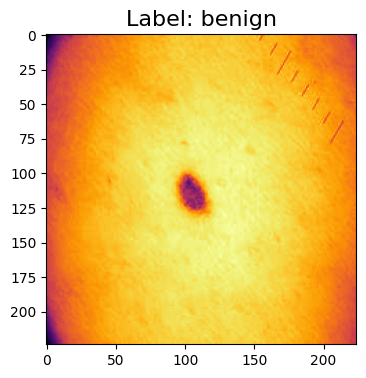

In [ ]:
# Select random sample from train_df
idx = random.sample(train_df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(train_df.image_path[idx]), train_df.label[idx]

# View the random sample
view_sample(sample_image, sample_label, color_map='inferno')


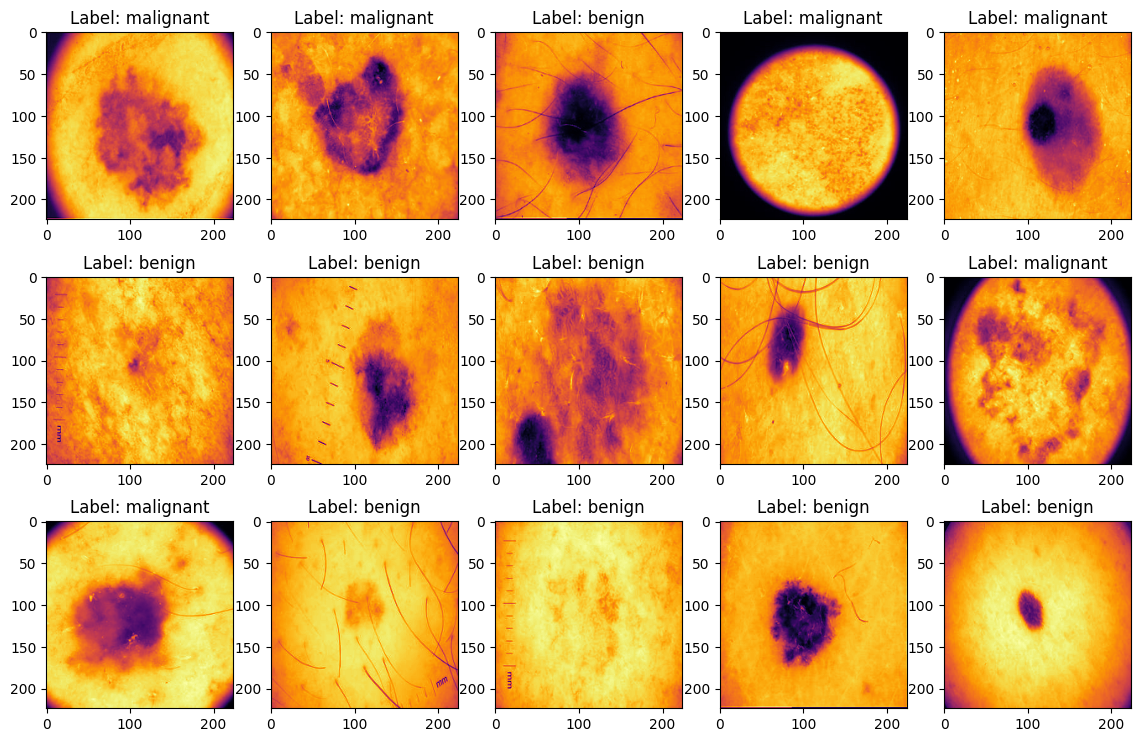

In [ ]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]))
        else:
            plt.imshow(tf.image.rgb_to_grayscale(sample_loader(df.image_path[_])), cmap=color_map)
    
    return

view_mulitiple_samples(train_df, _load, 
                       count=15, color_map='inferno', 
                       fig_size=(14, 9))

## **Training and Testing Dataset**

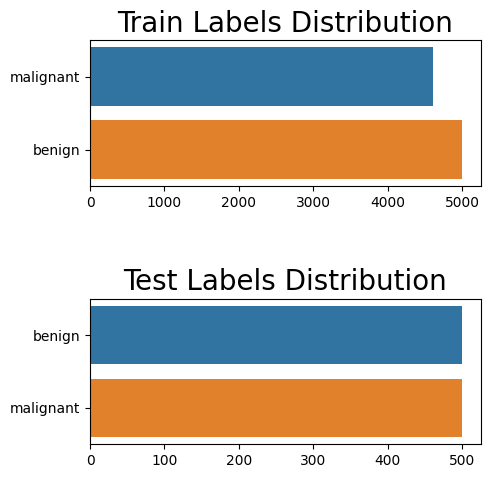

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

## **Spiltting Training into Training and Validation dataset**

In [ ]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.2,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [ ]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((7684, 3), (1921, 3))

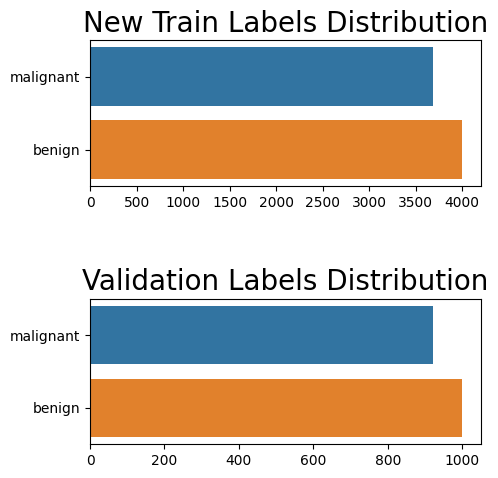

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 6))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot New Train Labels Distribution
ax1.set_title('New Train Labels Distribution', fontsize=20)
train_new_distribution = train_new_df['label'].value_counts().sort_values()
sns.barplot(x=train_new_distribution.values,
            y=list(train_new_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Validation Labels Distribution
ax2.set_title('Validation Labels Distribution', fontsize=20)
val_distribution = val_df['label'].value_counts().sort_values()
sns.barplot(x=val_distribution.values,
            y=list(val_distribution.keys()),
            orient="h",
            ax=ax2);

## **Augmentation Layer**

In [ ]:
# Build augmentation layer
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

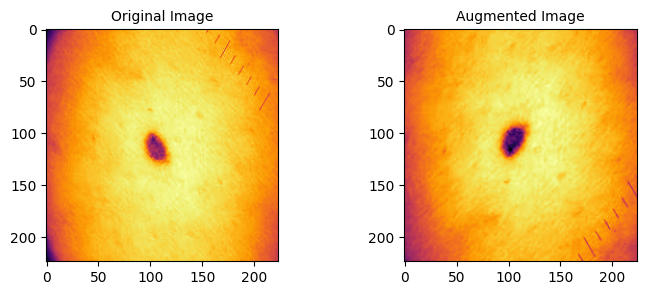

In [ ]:
image = tf.image.rgb_to_grayscale(sample_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=10)
ax1.imshow(image, cmap='inferno');

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=10)
ax2.imshow(augmentation_layer(image), cmap='inferno');

## **Pipelines: Training, Validation and Testing**

In [ ]:
def encode_labels(labels, encode_depth=2):
    return tf.one_hot(labels, depth=encode_depth).numpy()

def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    '''
    Generates an input pipeline using the tf.data API given a Pandas DataFrame and image loading function.
    
    @params
        - df: (pd.DataFrame) -> DataFrame containing paths and labels 
        - load_function: (function) -> function used to load images given their paths
        - augment: (bool) -> condition for applying augmentation
        - batch_size: (int) -> size for batched (default=32) 
        - shuffle: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        - cache: (str) -> cache path for caching data, data is not cached when None (default=None)
        - prefetch: (bool) -> condition for prefeching data, data is prefetched when True (default=False)
        
    @returns
        - dataset: (tf.data.Dataset) -> dataset input pipeline used to train a TensorFlow model
    '''
    # Get image paths and labels from DataFrame
    image_paths = df.image_path
    image_labels = encode_labels(df.label_encoded)
    AUTOTUNE = tf.data.AUTOTUNE
    
    # Create dataset with raw data from DataFrame
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    # Map augmentation layer and load function to dataset inputs if augment is True
    # Else map only the load function
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (load_function(x), y), num_parallel_calls=AUTOTUNE)
    
    # Apply shuffling based on condition
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    # Apply batching
    ds = ds.batch(batch_size)

    # Apply caching based on condition
    # Note: Use cache in memory (cache='') if the data is small enough to fit in memory!!!
    if cache != None:
        ds = ds.cache(cache)
    
    # Apply prefetching based on condition
    # Note: This will result in memory trade-offs
    if prefetch:
        ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    # Return the dataset
    return ds

In [ ]:
# Generate Train Input Pipeline
train_ds = create_pipeline(train_new_df, _load, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=False, prefetch=True)

# Generate Validation Input Pipeline
val_ds = create_pipeline(val_df, _load, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)

# Generate Test Input Pipeline
test_ds = create_pipeline(test_df, _load, 
                          batch_size=CFG.BATCH_SIZE, 
                          shuffle=False, prefetch=False)

In [ ]:
# View string representation of datasets
print('========================================')
print('Train Input Data Pipeline:\n\n', train_ds)
print('========================================')
print('Validation Input Data Pipeline:\n\n', val_ds)
print('========================================')
print('Test Input Data Pipeline:\n\n', test_ds)
print('========================================')

Train Input Data Pipeline:

 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Validation Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>
Test Input Data Pipeline:

 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## **CNN Model**

In [ ]:
def cnn_model():
    
    initializer = tf.keras.initializers.GlorotNormal()
    
    cnn_sequential = Sequential([
        layers.Input(shape=CFG.IMAGE_SIZE, dtype=tf.float32, name='input_image'),
        
        layers.Conv2D(16, kernel_size=3, activation='relu', padding='Same', kernel_initializer=initializer),
        layers.Conv2D(16, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        layers.Dropout(0.2),
        layers.Conv2D(8, kernel_size=3, activation='relu', padding='Same', kernel_initializer=initializer),
        layers.Conv2D(8, kernel_size=3, activation='relu', kernel_initializer=initializer),
        layers.MaxPool2D(pool_size=2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(2, activation='sigmoid', kernel_initializer=initializer)
    ], name='cnn_sequential_model')
    
    return cnn_sequential

## **Model Summary**

In [ ]:
# Generate Model
model_cnn = cnn_model()

# Generate Summary of the Model
model_cnn.summary()

Model: "cnn_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 8)       1160      
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 8)       584       
                                              

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## **Visualization of Model Layers**

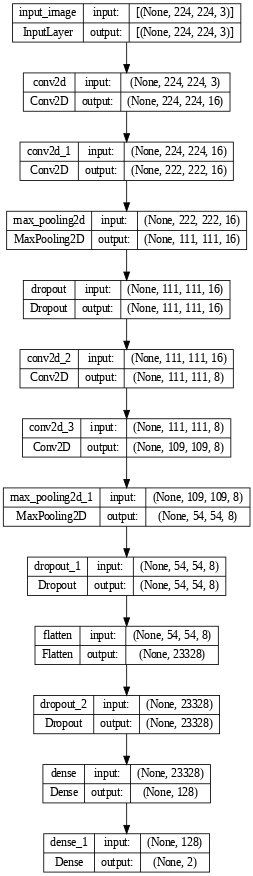

In [ ]:
# Explore model visually
plot_model(
    model_cnn, dpi=60,
    show_shapes=True
)

## **Training Model**

In [ ]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False):
    '''
        Trains a TensorFlow model and returns a dict object containing the model metrics history data. 
        
        @params
        - model: (tf.keras.model) -> model to be trained 
        - num_epochs: (int) -> number of epochs to train the model
        - callbacks_list: (list) -> list containing callback fuctions for model
        - tf_train_data: (tf.data.Dataset) -> dataset for model to be train on 
        - tf_valid_data: (tf.data.Dataset) -> dataset for model to be validated on (default=None)
        - shuffling: (bool) -> condition for data shuffling, data is shuffled when True (default=False)
        
        @returns
        - model_history: (dict) -> dictionary containing loss and metrics values tracked during training
    '''
    
    model_history = {}

    if tf_valid_data != None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  validation_data=tf_valid_data,
                                  validation_steps=int(len(tf_valid_data)),
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
        
    if tf_valid_data == None:
        model_history = model.fit(tf_train_data,
                                  epochs=num_epochs,
                                  callbacks=callbacks_list,
                                  shuffle=shuffling)
    return model_history

## **Early Stopping Callback & Reduce Learning Rate Callback**

In [ ]:
# Define Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True)

# Define Reduce Learning Rate Callback
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.1,
    verbose=1)

# Define Callbacks and Metrics lists
CALLBACKS = [early_stopping_callback, reduce_lr_callback]
METRICS = ['accuracy']

## **Model Training with Epoch**

In [ ]:
tf.random.set_seed(CFG.SEED)

# Compile the model
model_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=METRICS
)

# Train the model
print(f'Training {model_cnn.name}.')
print(f'Train on {len(train_new_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

cnn_history = train_model(
    model_cnn, CFG.EPOCHS, CALLBACKS, 
    train_ds, val_ds,
    shuffling=False
)

Training cnn_sequential_model.
Train on 7684 samples, validate on 1921 samples.
----------------------------------
Epoch 1/25
241/241 [==============================] - 96s 339ms/step - loss: 0.5376 - accuracy: 0.6861 - val_loss: 0.4379 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 2/25
241/241 [==============================] - 72s 298ms/step - loss: 0.3171 - accuracy: 0.8585 - val_loss: 0.3509 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 3/25
241/241 [==============================] - 70s 289ms/step - loss: 0.2867 - accuracy: 0.8752 - val_loss: 0.3043 - val_accuracy: 0.8745 - lr: 0.0010
Epoch 4/25
241/241 [==============================] - 72s 299ms/step - loss: 0.2833 - accuracy: 0.8829 - val_loss: 0.2837 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 5/25
241/241 [==============================] - 71s 294ms/step - loss: 0.2688 - accuracy: 0.8861 - val_loss: 0.2815 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 6/25
241/241 [==============================] - 74s 307ms/step - loss: 0.2652 - accuracy:

## **Model Evaluation**

In [ ]:
# Evaluate the model
cnn_evaluation = model_cnn.evaluate(test_ds)

32/32 [==============================] - 4s 138ms/step - loss: 0.2234 - accuracy: 0.9070


In [ ]:
# Generate model probabilities and associated predictions
cnn_test_probabilities = model_cnn.predict(test_ds, verbose=1)
cnn_test_predictions = tf.argmax(cnn_test_probabilities, axis=1)

32/32 [==============================] - 3s 91ms/step


## **Plotting Loss and Accuracy metrics for model**

In [ ]:
def plot_training_curves(history):
    
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

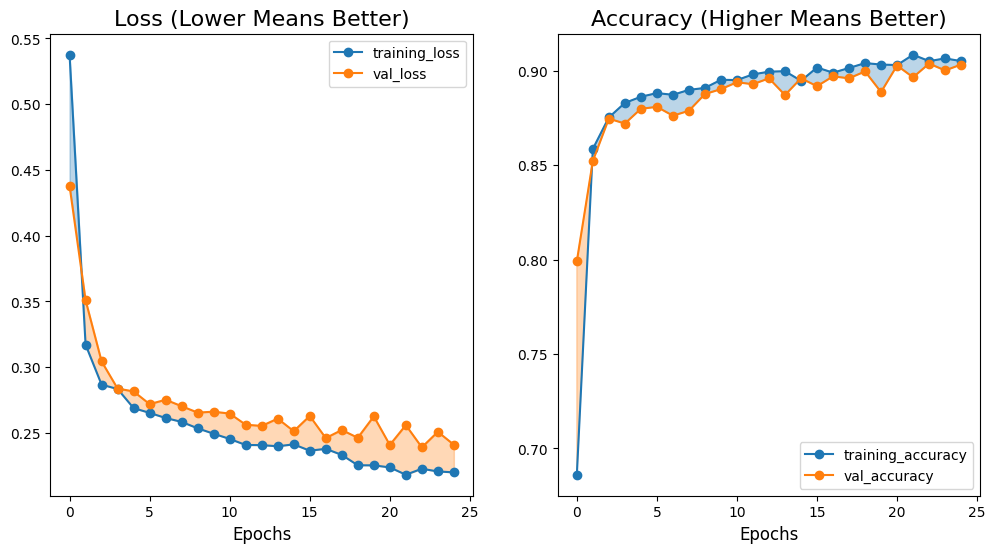

In [ ]:
# plot cnn model training history 
plot_training_curves(cnn_history)

## **Plotting Confusion Matrix**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=6): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=1, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=15)
    disp.set_xlabel('Predicted Label', fontsize=12) 
    disp.set_ylabel('True Label', fontsize=12)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return

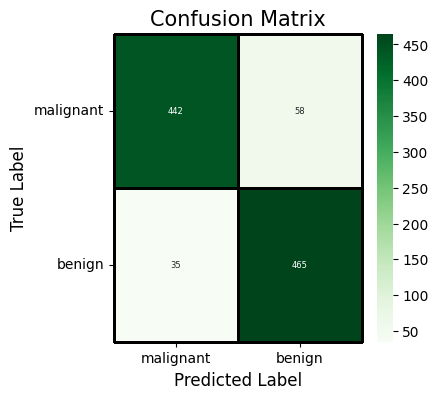

In [ ]:
class_names = ['malignant', 'benign']

plot_confusion_matrix(
    test_df.label_encoded, 
    cnn_test_predictions, 
    figsize=(4, 4), 
    classes=class_names)

## **Plotting ROC Curve**

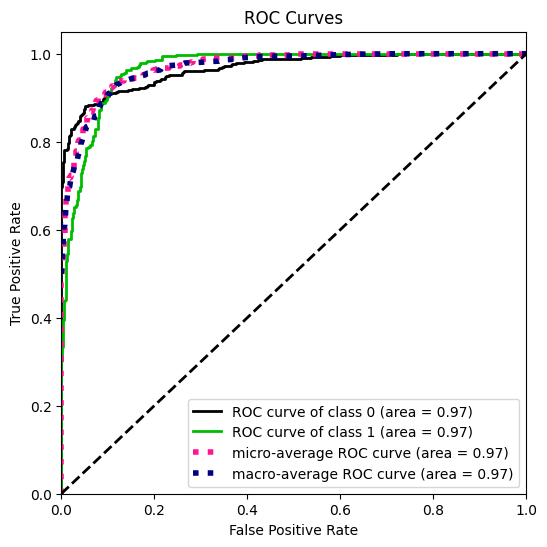

In [ ]:
plot_roc(test_df.label_encoded, 
         cnn_test_probabilities, 
         figsize=(6, 6), title_fontsize='large');

In [ ]:
# CNN Clasification Report
print(classification_report(test_df.label_encoded, 
                            cnn_test_predictions, 
                            target_names=class_names))

              precision    recall  f1-score   support

   malignant       0.93      0.88      0.90       500
      benign       0.89      0.93      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



## **Performance Evaluation based on Metrics**

In [ ]:
def generate_preformance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, 
                                                                                 y_pred, 
                                                                                 average="weighted")
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score': model_accuracy,
        'precision_score': model_precision,
        'recall_score': model_recall,
        'f1_score': model_f1,
        'matthews_corrcoef': model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
# Generate CNN model performance scores
cnn_performance = generate_preformance_scores(test_df.label_encoded, 
                                              cnn_test_predictions, 
                                              cnn_test_probabilities)



Performance Metrics:

accuracy_score:		0.9070

_____________________________________________
precision_score:	0.9079

_____________________________________________
recall_score:		0.9070

_____________________________________________
f1_score:		0.9070

_____________________________________________
matthews_corrcoef:	0.8149

